In [2]:
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import cv2
import glob
from camera_intrinsic import get_camera_intrinsics
from exif_extract import transform_jpeg_to_depthmap_samsungs20
from exif_extract import transform_jpeg_to_depthmap_iphone
from binary_dm import transform_binary_to_depthmap

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


  # Standard Variablen
Extraktion der Tiefenkarte

## Tiefenkarte und RGB-Daten extrahieren

IPhone Daten  aus Exif

In [3]:
url_Iphone = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\IphoneTestBilder\Küche\Box\IMG_8680_max52cm_min45cm.jpg"
output_dir_Iphone = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\IPhoneTiefenkarten"

rgb_url_Iphone, depth_url_Iphone = transform_jpeg_to_depthmap_iphone(url_Iphone, output_dir_Iphone) #Nutzung unserer Funktion

#Open Images
depth_im_Iphone = Image.open(depth_url_Iphone)  # Quelle: https://stackoverflow.com/a/67346474
rgb_im_Iphone = Image.open(rgb_url_Iphone)

True
Die Tiefenkarte existiert bereits


IPhone Daten aus Xcode 

In [4]:
binary_url = r"C:\Users\Diren\Nextcloud\DepthMap4.bin"
transform_binary_to_depthmap(binary_url)

array([[0.2502, 0.2502, 0.2534, ..., 0.2135, 0.2073, 0.2197],
       [0.2468, 0.244 , 0.2544, ..., 0.2103, 0.2128, 0.1843],
       [0.2615, 0.2429, 0.254 , ..., 0.2067, 0.2251, 0.1938],
       ...,
       [0.2227, 0.218 , 0.2299, ..., 0.2062, 0.2168, 0.2299],
       [0.213 , 0.2186, 0.2355, ..., 0.219 , 0.2151, 0.2338],
       [0.1919, 0.177 , 0.2175, ..., 0.2067, 0.2153, 0.2617]],
      dtype=float16)

Resize RGB image to size of depthmap (only for exif data)

We need to resize the rgb image later to this size to combine depth map and RGB image and create a RGBD image. First we get the size of the depth map and then resize the RGB image to that size.

In [5]:
def resize(rgb_im, depth_im):
    rgb_width, rgb_height = rgb_im.size
    rgb_width_original, rgb_height_original = rgb_im.size #need that for later use
    dm_width, dm_height = depth_im.size  # width and height of depth map image. 
    
    print(f"dm_height:{dm_height}, dm_width:{dm_width}\n rgb_height:{rgb_height}, rgb_width:{rgb_width}")  # need to scale our RGB image to the size of our depthmap image
    
    size = (dm_width, dm_height)  # define new size
    rgb_im = rgb_im.resize(size)  # fitting the rgb image size to the size of the depth image
    
    rgb_width, rgb_height = rgb_im.size
    print(f"new_rgb_height:{rgb_height}, new_rgb_width:{rgb_width}")
    
    return rgb_im, dm_width, dm_height, rgb_width_original, rgb_height_original

Resize Iphone RGB Image

In [6]:
rgb_im_Iphone, dm_width_Iphone, dm_height_Iphone, rgb_width_Iphone, rgb_height_Iphone = resize(rgb_im_Iphone, depth_im_Iphone)

dm_height:576, dm_width:768
 rgb_height:3024, rgb_width:4032
new_rgb_height:576, new_rgb_width:768


Getting the images as numpy arrays for later use

Iphone array

In [7]:
depth_array_Iphone = np.array(depth_im_Iphone)  # getting the depthmap as a numpy array
rgb_array_Iphone = np.array(rgb_im_Iphone)  # getting the rgb image as a numpy array

We need the images as open3d objects or else we can´t create the RGBD image

Iphone o3d object

In [8]:
# convert the arrays to open3d objects Quelle: https://stackoverflow.com/questions/63587617/how-to-create-a-rgbd-image-from-numpy-rgb-array-and-depth-array
rgb_o3d_Iphone = o3d.geometry.Image(rgb_array_Iphone)
depth_o3d_Iphone = o3d.geometry.Image(depth_array_Iphone)
#depth_3d = o3d.geometry.Image(np.ascontiguousarray(depth_array_Iphone))

# Processing depth map

Plotting the Iphone depthmap 

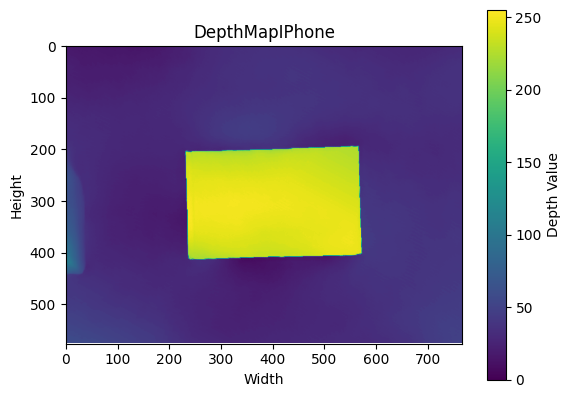

In [9]:
# plotting the depthmap
plt.imshow(depth_array_Iphone)
plt.colorbar(label="Depth Value")
plt.title("DepthMapIPhone")
plt.ylabel("Height")
plt.xlabel("Width")
plt.show()


In [12]:
depth_array_Iphone.shape

(576, 768)

## Scale depth map to real values

Übersetzen der Uint8 Werte in Floats

In [10]:

# Float Min/Max Values aus EXIF-Daten
float_min = 0.45
float_max = 0.52

# Umgekehrte Skalierung der Tiefenwerte. Umgekehrt, da die originale Tiefenkarte scheinbar invertiert ist.
depth_map_meters = float_max - (depth_array_Iphone / 255.0) * (float_max - float_min)


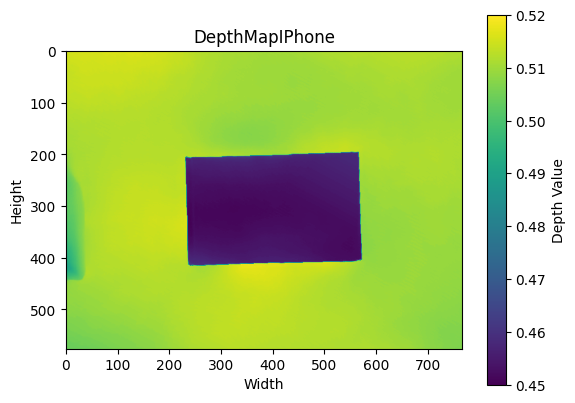

In [11]:
# plotting the depthmap
plt.imshow(depth_map_meters)
plt.colorbar(label="Depth Value")
plt.title("DepthMapIPhone")
plt.ylabel("Height")
plt.xlabel("Width")
plt.show()

 Processing Depth Map

Filterung

# Create RGBD image

 RGBD Image

In [ ]:
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_o3d_Iphone, depth_o3d_Iphone)  # Quelle:https://www.open3d.org/docs/latest/python_api/open3d.geometry.RGBDImage.html und https://stackoverflo.com/questions/63587617/how-to-create-a-rgbd-image-from-numpy-rgb-array-and-depth-array

Comparison of RGB and depth map image

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Farbbild")
plt.imshow(rgbd.color)
plt.subplot(1, 2, 2)
plt.title("Tiefenbild")
plt.imshow(rgbd.depth)
plt.show()

# Get camera intrinsics

With the intrinsics of the camera that took the photo we are able to correct distortions 

## OpenCV camera calibration

In [ ]:
images = glob.glob(r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\Chesspattern\8x11_normalCamera\*.jpg") #checkerboard pictures for calibration

In [ ]:
ret,mtx,dist,rvecs,tvecs, reprojection_error = get_camera_intrinsics(images)

because the depthmap image is 768x576 and i can´t calibrate the lidar sensor directly, i will scale the matrix (mtx) and distortion coefficients (dist) of the normal camera down. 

In [ ]:
original_width, original_height = 3024, 4032

# sclaingfactor
scale_x = dm_width_Iphone / rgb_width_Iphone
scale_y = dm_height_Iphone / rgb_height_Iphone

# scaling
scaled_mtx = mtx.copy()
scaled_mtx[0, 0] *= scale_x  # f_x
scaled_mtx[1, 1] *= scale_y  # f_y
scaled_mtx[0, 2] *= scale_x  # c_x
scaled_mtx[1, 2] *= scale_y  # c_y

print("Angepasste intrinsische Matrix:")
print(scaled_mtx)

## Exiftool camera calibration

intrinsische Matrix und distortion_coefficients via exif

In [ ]:
mtx_exif = np.array([
    [2878.218994140625, 0.0, 1509.392333984375],
    [0.0, 2878.218994140625, 2012.1256],
    [0.0, 0.0, 1.0]
])


In [ ]:
distortion_coefficients_exif = np.array([
    -0.35576209425926208,  # k1
    -0.0066862036474049091,  # k2
    0.0057414853945374489,  # p1
    -0.00049229874275624752,  # p2
    1.8682043446460739e-05,  # k3
    -3.3853208947220992e-07,  # k4
    2.383720332232997e-09   # k5
])

In [ ]:
distortion_coefficients_exif = distortion_coefficients_exif[:5]

Wir müssen die Exif mxt anpassen, da die Werte für die Abmessung des RGB-Bilds abgestimmt sind und nun auf die Abmessung der Tiefenkarte skaliert werden muss.

In [ ]:
# sclaingfactor
scale_x = dm_width_Iphone / rgb_width_Iphone
scale_y = dm_height_Iphone / rgb_height_Iphone

# scaling
scaled_mtx_exif = mtx_exif.copy()
scaled_mtx_exif[0, 0] *= scale_x  # f_x
scaled_mtx_exif[1, 1] *= scale_y  # f_y
scaled_mtx_exif[0, 2] *= scale_x  # c_x
scaled_mtx_exif[1, 2] *= scale_y  # c_y

print("Angepasste intrinsische Matrix:")
print(scaled_mtx_exif)

because the depthmap is already processes by the IPhone and normalized, I have to scale to numbers back to meters. the maximum depth captured by the LIDAR sensor seems to be 5 meters.
so the maximum value of the unedited array, which is 255, is equal to 5 meters while 0 = 0 meters.

scaled intrinsic

In [ ]:
fx = scaled_mtx_exif[0, 0]
fy = scaled_mtx_exif[1, 1]
cx = scaled_mtx_exif[0, 2]
cy = scaled_mtx_exif[1, 2]

print(f"fx: {fx}, fy: {fy}, cx: {cx}, cy: {cy}")


# Intrinsic Matrix als Open3D-Objekt
intrinsic_exif_scaled = o3d.camera.PinholeCameraIntrinsic(width=dm_width_Iphone,height=dm_height_Iphone, fx=fx, fy=fy, cx=cx, cy=cy)


unscaled intrinsic

In [ ]:
fx = mtx_exif[0, 0]
fy = mtx_exif[1, 1]
cx = mtx_exif[0, 2]
cy = mtx_exif[1, 2]

print(f"fx: {fx}, fy: {fy}, cx: {cx}, cy: {cy}")


# Intrinsic Matrix als Open3D-Objekt
intrinsic_exif = o3d.camera.PinholeCameraIntrinsic(width=dm_width_Iphone,height=dm_height_Iphone, fx=fx, fy=fy, cx=cx, cy=cy)


# Create point cloud

Open3D Object without metric scaling

In [ ]:
depth_data_uint16_Iphone = (depth_array_Iphone.astype(np.uint16)) #Quelle: https://stackoverflow.com/questions/73067231/how-to-convert-uint8-image-to-uint16-python
depth_uint16_o3d_Iphone = o3d.geometry.Image(depth_data_uint16_Iphone)

Metric Open3D Object

In [ ]:
depth_data_uint16_Iphone_metric = (depth_map_meters * 1000).astype(np.uint16)  # Meter -> Millimeter
depth_uint16_o3d_Iphone_metric = o3d.geometry.Image(depth_data_uint16_Iphone_metric)


The PCD looks more accurate when scaling the intrinsic matrix first

## Point cloud only from depth image

PCD Iphone

PCD without metric scaling

In [ ]:

# Open3D-Image aus Tiefenkarte erstellen
depth_image = o3d.geometry.Image(depth_uint16_o3d_Iphone)

# Punktwolke aus Tiefenkarte erstellen
pcd_Iphone_int = o3d.geometry.PointCloud.create_from_depth_image(
    depth_image,
    intrinsic=intrinsic_exif_scaled
    #depth_scale=1000.0,  # Skalierungsfaktor für Millimeter
    #depth_trunc=1000.0,  # Maximale Tiefe in Millimetern
)


In [ ]:
o3d.visualization.draw_geometries([pcd_Iphone_int])

Metric PCD

In [ ]:
depth_image_metric = o3d.geometry.Image(depth_uint16_o3d_Iphone_metric)

pcd_Iphone_metric = o3d.geometry.PointCloud.create_from_depth_image(
    depth_image_metric,
    intrinsic=intrinsic_exif_scaled,
    depth_scale=1000.0,  # Skalierungsfaktor für Millimeter
    depth_trunc=3000.0,  # Maximale Tiefe in Millimetern
)


In [ ]:
o3d.visualization.draw_geometries([pcd_Iphone_metric])

## Point cloud only from RGBD image

In [ ]:
pcrgbd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic_exif_scaled)
o3d.visualization.draw_geometries([pcrgbd])

# Clean Point Cloud

To get better results from the PC for the volume estimation I will clean it using Open3D methods

In [ ]:
pcd_center = pcd_Iphone_metric.get_center()
pcd_Iphone_metric.translate(pcd_center)

## Voxelization

In [ ]:
#pcd_Iphone_metric = pcd_Iphone_metric.voxel_down_sample(voxel_size=0.0000005)
#o3d.visualization.draw_geometries([pcd_Iphone_metric])

## Statistical oulier removal (SOR)
Bereinigung der Punktwolke mit Statistical Outlier Removal

In [ ]:
#Quelle: https://www.open3d.org/docs/latest/tutorial/Advanced/pointcloud_outlier_removal.html

def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

Removing the outliers

In [ ]:
cl, ind = pcd_Iphone_metric.remove_statistical_outlier(nb_neighbors=100, std_ratio=3.0) #gute Ergebnisse mit diesen Werten bisher

Displaying inlier in grey and outlier in red

In [ ]:
display_inlier_outlier(pcd_Iphone_metric, ind)

We will use this PC from now on

In [ ]:
# Cleaned PC
pcd_Iphone_metric = pcd_Iphone_metric.select_by_index(ind)  # Nur Inlier

Visualizing the new PC

In [ ]:
#o3d.visualization.draw_geometries([pcd_Iphone_metric])

## Estimating normals

In [ ]:
nn_distance = np.mean(pcd_Iphone_metric.compute_nearest_neighbor_distance())

print(nn_distance)

In [ ]:
radius_normals = nn_distance * 4

pcd_Iphone_metric.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)

pcd_Iphone_metric.paint_uniform_color([0.6, 0.6, 0.6])
o3d.visualization.draw_geometries([pcd_Iphone_metric])

## Plane segmentation with RANSAC

In [ ]:
plane_model, inliers = pcd_Iphone_metric.segment_plane(
    distance_threshold=0.01,
    ransac_n=10,
    num_iterations=6000,
    probability=1
)

[a, b, c, d] = plane_model.tolist()

# Inlier- und Outlier-Punktwolken
inlier_cloud = pcd_Iphone_metric.select_by_index(inliers)
inlier_cloud = inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd_Iphone_metric.select_by_index(inliers, invert=True)

# Darstellung der Punktwolken
o3d.visualization.draw_geometries(
    [inlier_cloud, outlier_cloud])


In [ ]:
pcd_Iphone_metric = outlier_cloud

In [ ]:
o3d.visualization.draw_geometries([pcd_Iphone_metric], window_name="")

## SOR again

In [ ]:
#ggf. kann man für die restlichen punkte nun wieder SOR nutzen?
cl, ind = pcd_Iphone_metric.remove_statistical_outlier(nb_neighbors=1000, std_ratio=3.0) 

In [ ]:
display_inlier_outlier(pcd_Iphone_metric, ind)

In [ ]:
# Cleaned PC
pcd_Iphone_metric = pcd_Iphone_metric.select_by_index(ind)  # Nur Inlier

Visualizing the new PC

In [ ]:
o3d.visualization.draw_geometries([pcd_Iphone_metric])

## Hidden point removal

# Sonstiges/Tests

## DBSCAN-Clustering
Ggf. brauchen wir DBSACN nicht, da wir die Tischebene behalten wollen.

In [ ]:
# DBSCAN-Clustering
eps = 0.02  # Radius für Nachbarn
min_points = 50  # Mindestanzahl von Punkten in einem Cluster
labels = np.array(pcd_Iphone_metric.cluster_dbscan(eps=eps, min_points=min_points, print_progress=True))

num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Anzahl der Cluster: {num_clusters}")

# colors for clusters
colors = plt.get_cmap("tab20")(labels / (num_clusters if num_clusters > 0 else 1))
colors[labels < 0] = 0  # Rauschen (Label -1) schwarz färben
pcd_Iphone_metric.colors = o3d.utility.Vector3dVector(colors[:, :3])

o3d.visualization.draw_geometries([pcd_Iphone_metric])

In [ ]:
for cluster_id in np.unique(labels):
    cluster_size = np.sum(labels == cluster_id)
    if cluster_id == -1:
        print(f"Rauschen: {cluster_size} Punkte")
    else:
        print(f"Cluster {cluster_id}: {cluster_size} Punkte")

In [ ]:
# ID des zu entfernenden Clusters
cluster_to_remove = 1  # Ersetzen Sie dies durch die Cluster-ID des unerwünschten Clusters

# Indizes der Punkte im Cluster finden
indices_to_remove = np.where(labels == cluster_to_remove)[0]

# Punktwolke ohne das unerwünschte Cluster erstellen
remaining_cloud = pcd_Iphone_metric.select_by_index(indices_to_remove, invert=True)

# Visualisierung der bereinigten Punktwolke
o3d.visualization.draw_geometries([remaining_cloud], window_name="Bereinigte Punktwolke")


## Convex Hull
Die Konvexe Hülle wird ggf. relevant für die Volumenberechnung, sobald ich nur das Zielobjekt extrahieren kann. Problem ist nur bei dieser Methode, dass bspw. runde Objekte überschätzt werden. 

In [ ]:
scale_factor = 1000  # Skalieren um den Faktor 1000 (z. B. mm -> m)
remaining_cloud.scale(scale_factor, center=remaining_cloud.get_center())

In [ ]:
# calculate hull
hull_mesh, hull_vertices = remaining_cloud.compute_convex_hull()

hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull_mesh)

hull_ls.paint_uniform_color([1, 0, 0])

o3d.visualization.draw_geometries([remaining_cloud, hull_ls])


In [ ]:
# Konvexe Hülle aus der Punktwolke berechnen
hull, _ = remaining_cloud.compute_convex_hull()

#Volumen der konvexen Hülle berechnen
volume = hull.get_volume()

print(f"Volumen der konvexen Hülle: {volume:.2f} Einheiten^3")

In [ ]:
bounds = remaining_cloud.get_max_bound() - remaining_cloud.get_min_bound()
print(f"Ausdehnung der Punktwolke: x={bounds[0]:.2f}, y={bounds[1]:.2f}, z={bounds[2]:.2f}")


In [ ]:
print(f"Anzahl der Punkte in der konvexen Hülle: {len(hull.vertices)}")
print(f"Anzahl der Dreiecke in der konvexen Hülle: {len(hull.triangles)}")


In [ ]:
# Visualisierung der Hülle und Punktwolke
hull.paint_uniform_color([1, 0, 0])  # Hülle rot färben
o3d.visualization.draw_geometries([remaining_cloud, hull])

## Mesh
Ggf. auch interessant

## Interaktive PC

In [ ]:
# Punktwolke interaktiv anzeigen
print("Drücke 'Shift + Linksklick', um Punkte auszuwählen, und 'Shift + Rechtsklick', um Auswahl aufzuheben.")
picked_points = o3d.visualization.draw_geometries_with_editing([pcd_Iphone_metric])

# Ausgewählte Punkt-Indizes anzeigen
print(f"Ausgewählte Punkt-Indizes: {picked_points}")

In [ ]:
print(picked_points)

In [ ]:
import numpy as np

# Koordinaten der Punkte
point1 = np.array([0.23, 0.015, 0.45])  # Punkt 1 (#250552)
point2 = np.array([-0.04, 0.025, 0.46])  # Punkt 2 (#52765)

# Euklidische Distanz berechnen
distance = np.linalg.norm(point2 - point1)

# Ergebnis ausgeben
print(f"Abstand zwischen den Punkten: {distance:.6f} Einheiten")


weiteres

In [ ]:
# Punktkoordinaten abrufen
points = np.asarray(pcd_Iphone_metric.points)

# Minimum und Maximum der Z-Achse (Tiefe) prüfen
min_z = np.min(points[:, 2])
max_z = np.max(points[:, 2])

print(f"Minimale Z-Tiefe: {min_z}")
print(f"Maximale Z-Tiefe: {max_z}")